## a working example of a multivariate transfer function 

* Requires the following branch on my fork: https://github.com/chrishavlin/yt/tree/figuring_out_mf_tfs
* See https://github.com/yt-project/yt/issues/5257 for some extra discussion.



In [1]:
import numpy as np

import yt
from yt.visualization.volume_rendering.transfer_functions import (
    MultiVariateTransferFunction,
    TransferFunction,
)
import unyt 
import matplotlib.pyplot as plt 

ds = yt.load("Enzo_64/DD0043/data0043")

yt : [INFO     ] 2025-08-19 21:43:11,655 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2025-08-19 21:43:11,655 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-08-19 21:43:11,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-19 21:43:11,656 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-19 21:43:11,657 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-08-19 21:43:11,657 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2025-08-19 21:43:11,658 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-08-19 21:43:11,658 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-08-19 21:43:11,659 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-08-19 21:43:11,659 Parameters: hubble_constant           = 0.71


In [2]:



dens_bounds = (-32, -27)
def _renormalized_dens(field, data): 
    dens = np.log10(data["gas", "density"].copy().d )
    dens = ((dens - dens_bounds[0]) / (dens_bounds[1] - dens_bounds[0]))**2
    dens[dens < 0] = 0 
    dens[dens > 1] = 1    
    return unyt.unyt_array(dens, "")

ds.add_field(('gas', 'renormalized_density'), 
             _renormalized_dens, 
             sampling_type="local", 
             units="", 
             take_log=False,
             force_override=True)

T_bounds = (3.2, 8)
def _renormalized_T(field, data): 
    vals = np.log10(data["gas", "temperature"].copy().d )
    vals = ((vals - T_bounds[0]) / (T_bounds[1] - T_bounds[0]))**2
    vals[vals < 0] = 0 
    vals[vals > 1] = 1    
    return unyt.unyt_array(vals, "")

ds.add_field(('gas', 'renormalized_temperature'), 
             _renormalized_T, 
             sampling_type="local", 
             units="", 
             take_log=False,
             force_override=True)


mv = MultiVariateTransferFunction(grey_opacity=False)


green = TransferFunction((0, 1))
green.y = 0.2 * np.exp(-(((green.x - 0.4) / 0.05) ** 2))

red = TransferFunction((0, 1))
red.y = 0.5 * np.exp(-((red.x)/0.4)**2)


blue = TransferFunction((0, 1))
blue.y = np.exp(-((blue.x - 1)/0.4)**2)

for ich, tf in enumerate([red, green, blue]):
    mv.add_field_table(tf, 0, weight_table_id=3+ich)
    mv.link_channels(ich, ich)



alpha = TransferFunction((0., 1))
alpha.y = 0.01 + alpha.x **2
alpha.y[alpha.y>1] = 1.0
for ich in range(3):
    mv.add_field_table(alpha, 1)
    mv.link_channels(ich + 3, ich + 3)

Parsing Hierarchy : 100%|██████████████████| 752/752 [00:00<00:00, 17633.47it/s]
yt : [INFO     ] 2025-08-19 21:43:11,744 Gathering a field list (this may take a moment.)


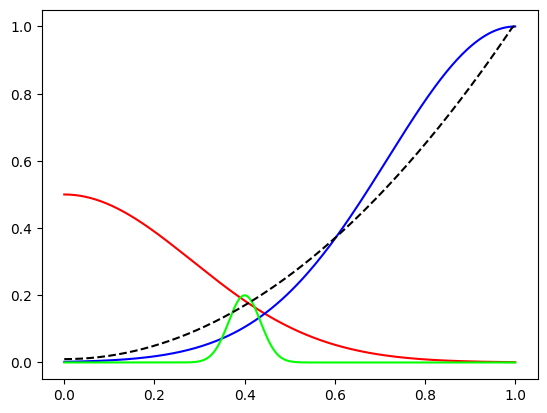

In [3]:
import matplotlib.pyplot as plt 

plt.plot(red.x, red.y, color='red')
plt.plot(blue.x, blue.y, color='blue')
plt.plot(green.x, green.y, color=(0,1,0))
plt.plot(alpha.x, alpha.y, '--k')

yt : [INFO     ] 2025-08-19 21:43:12,597 Rendering scene (Can take a while).
yt : [INFO     ] 2025-08-19 21:43:12,599 Creating volume


adding weight field to volume
resetting fields


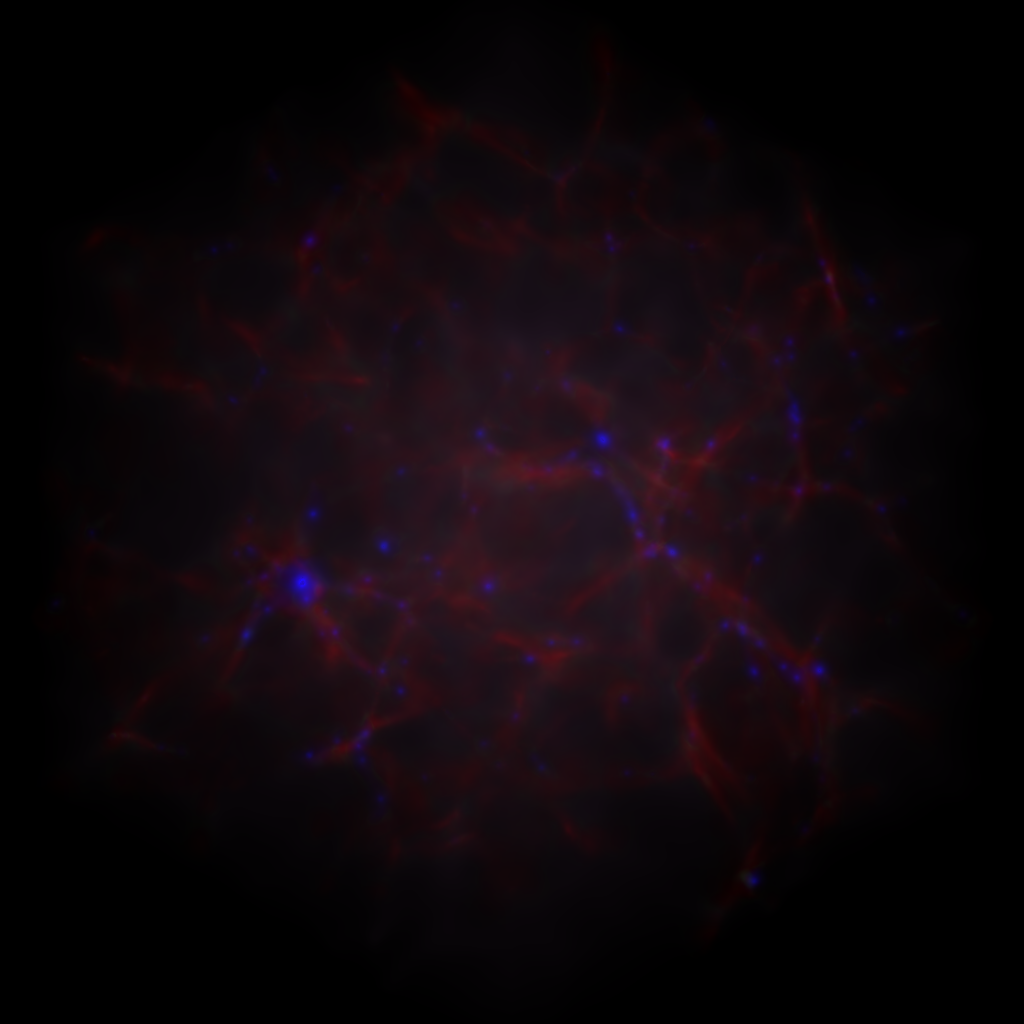

In [4]:
flds = [("gas", "renormalized_temperature"), ("gas", "renormalized_density")]

sc = yt.create_scene(ds.all_data(), flds)

cam = sc.camera
cam.set_resolution((1024,1024))
sc[0].log_field = False
sc[0].weight_field = flds[1]
sc[0].log_weight_field = False
_ = sc[0].set_transfer_function(mv)

sc.show()

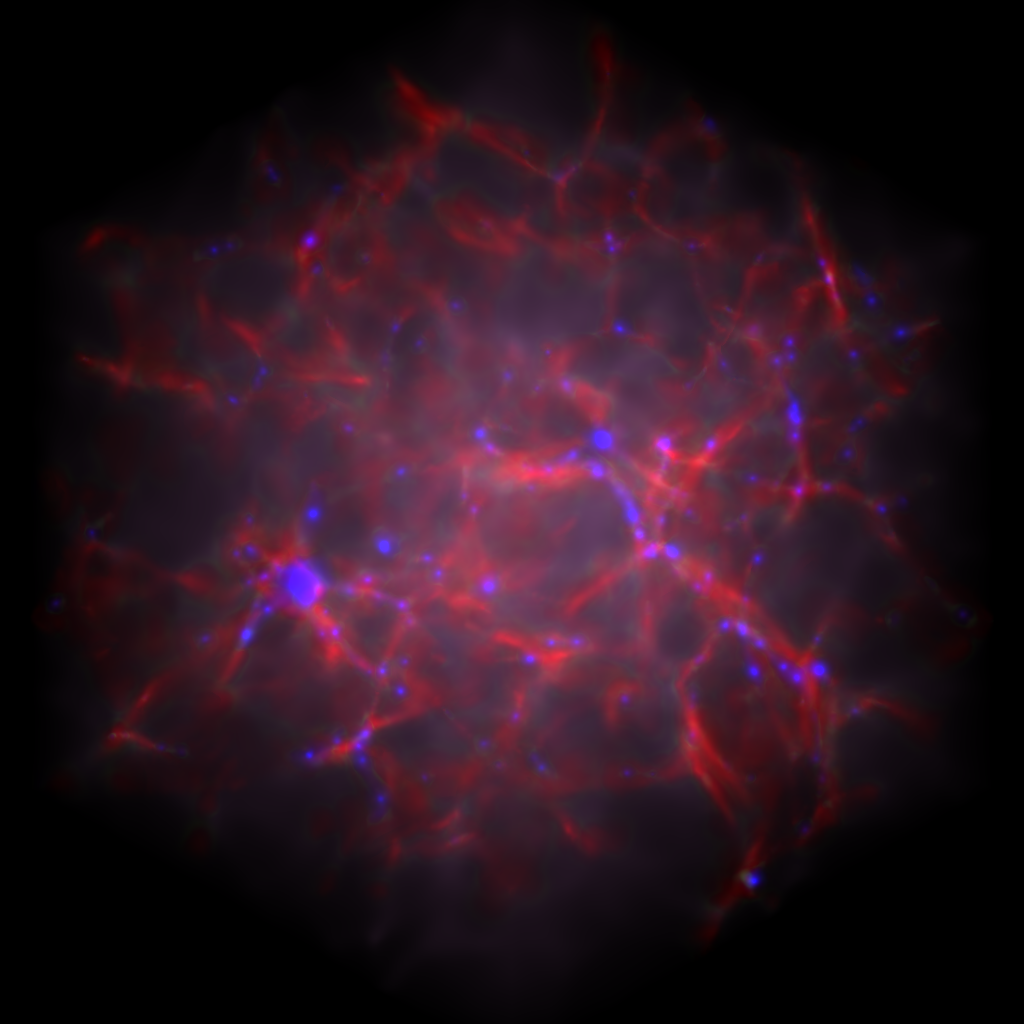

In [5]:
sc.show(sigma_clip=6)